In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import time
import copy
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import datetime
import os
import glob
%matplotlib inline

In [2]:
ox.config(data_folder='data', logs_folder='logs', 
          imgs_folder='imgs', cache_folder='cache',
          use_cache=True, log_console=True, 
          log_name='osmnx', log_file=True, log_filename='osmnx')

crs_osm = {'init':'epsg:4326'}           #crs that osm uses

In [3]:
def load_data():
    #Load the districts shapes
    folder = "data/l40-district"
    districts = gpd.GeoDataFrame.from_file('data/l40-district/001-budapest-01-kerulet.geojson')
    files = [file for file in os.listdir(folder)]
    #for file in os.listdir(folder):
    #    files.append(file)
    del files[2]

    districts=pd.concat([gpd.read_file('data/l40-district/{}'.format(file))for file in files
                        ]).pipe(gpd.GeoDataFrame)
    districts.crs = {'init': 'epsg:4326'}
    districts['ksh'] = districts.ksh.astype(int)
    districts.reset_index(drop=True, inplace=True)
    #districts=ox.project_gdf(districts)
    districts=ox.utils_geo.projection.project_gdf(districts)

    #Load the population data and merg it with the districts geodataframe
    df_population = pd.read_excel('data/BPPopulation.xlsx')
    districts = districts.merge(df_population, how='left',left_on='ksh',right_on='ksh')
    districts = ox.utils_geo.projection.project_gdf(districts, to_crs=crs_osm, to_latlong=True)
    return districts

In [4]:
def population_to_network(G, districts):
    '''
    Assign the district to which each node belongs to, the average district population, and average female and male district population.
    
    G: nx.MultiDigraph downloaded with OSMnx with the geographic properties
    districts: GeoPandas.DataFrame with the districts geometry, and population data
    
    returns:
    G: nx.MultiDiGraph with the following keys in the nodes:
        district: District in which each node is located
        population: Average district population that 'lives' in the node
        females: Average district female population that 'lives' in the node
        males: Average district male population that 'lives' in the node
    '''
    nodes = ox.graph_to_gdfs(G, edges=False)
    nodes = ox.utils_geo.projection.project_gdf(nodes, to_crs=crs_osm, to_latlong=True)
    nodes['district'] = 0
    found = set()
    population = {}
    for i,row in districts.iterrows():
        nodes_in = []
        for j, data in nodes.iterrows():
            if j not in found:
                if row['geometry'].contains(data['geometry']) == True:
                    found.add(j)
                    nodes_in.append(j)
        total_population = int(row['Total_population']/len(nodes_in))
        females = int(row['Females']/len(nodes_in))
        males = int(row['Males']/len(nodes_in))
        for x in nodes_in:
            population[x] = {'district':row['ksh'],'population':total_population,'females':females,'males':males}
    nx.set_node_attributes(G, population)
    G.remove_nodes_from([ n for n in G.nodes() if n not in found])
    return G

In [5]:
def keep_lcc(G_population):
    if len(list(nx.weakly_connected_component_subgraphs(G_population))) > 1:
        wcc = list(nx.weakly_connected_component_subgraphs(G_population))
        wcc.sort(key=len,reverse=True)
        G_population = wcc[0]
    return G_population

In [6]:
districts = load_data()

#networks = ['Budapest_walk_bike_pilot.graphml','Budapest_walk_bike_original.graphml']
networks = ['Budapest_walk_bike_pilot_2.graphml']
for network in networks:
    G = ox.load_graphml('data/networks/{}'.format(network), node_type=float)
    G_population = population_to_network(G, districts)
    G_population = keep_lcc(G_population)
    print(len(list(nx.weakly_connected_component_subgraphs(G_population))))
    ox.save_graphml(G_population,'data/networks/{}'.format(network))

1


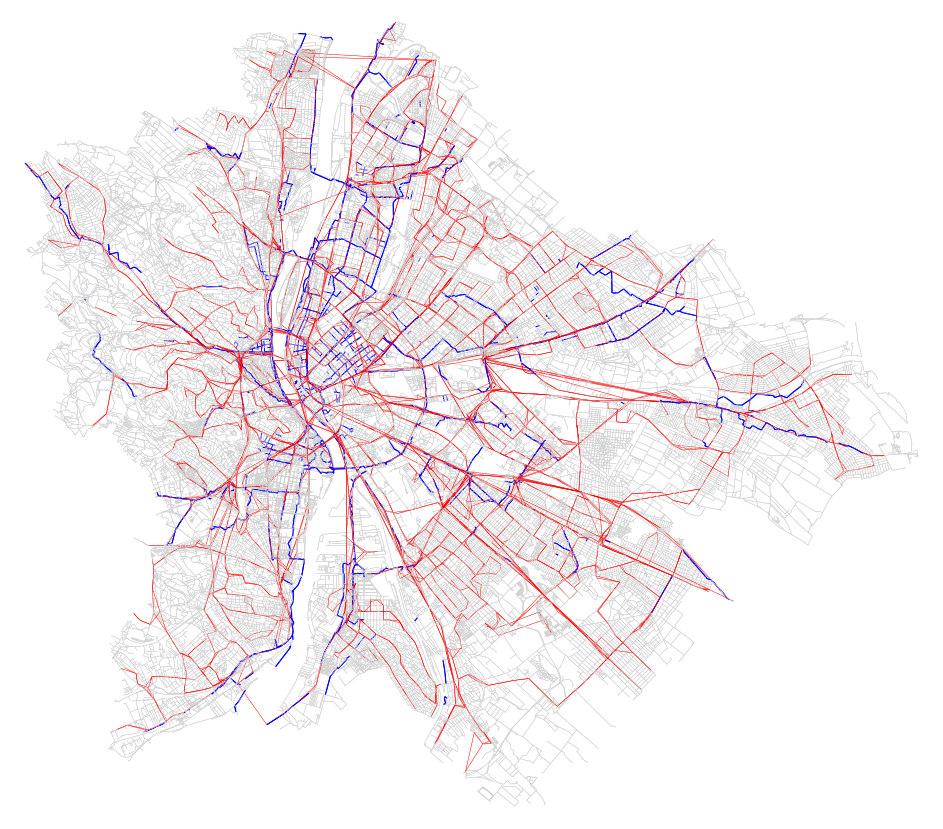

(<Figure size 1198.66x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a98204390>)

In [18]:
ec = ['blue' if edge['mode']=='bike' else 'red' if edge['mode']=='transit' else 'lightgray' for i,j,edge in G_population.edges(data=True)]
ew = [1 if edge['mode']=='bike' else 0.5 for i,j,edge in G_population.edges(data=True)]
G_population = ox.project_graph(G_population, to_crs={'init': 'epsg:32633'})
ox.plot_graph(G_population, node_size=0, edge_color=ec, edge_linewidth=ew,fig_height=15)

In [3]:
G = ox.load_graphml('data/networks/{}'.format('Budapest_walk_bike_original.graphml'), node_type=float)

In [4]:
list(G.nodes())[0]

5362155527.0

In [5]:
n, e = ox.graph_to_gdfs(G)

In [18]:
n.index = n.index.astype(int)
e.u = e.u.astype(int)
e.v = e.v.astype(int)

In [19]:
G = ox.graph_from_gdfs(n,e)

In [20]:
list(G.edges())[0]

(5362155527, 5362155528)

In [22]:
G = ox.save_graphml(G, 'data/networks/{}'.format('Budapest_walk_bike_original_int.graphml'))

In [23]:
G = ox.load_graphml('data/networks/{}'.format('Budapest_walk_bike_original_int.graphml'))
list(G.nodes())[0]

ValueError: invalid literal for int() with base 10: '5362155527.0'

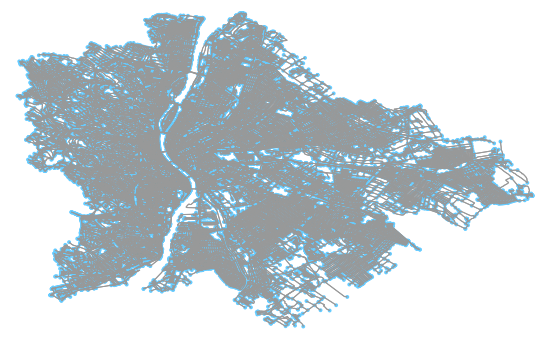

(<Figure size 691.337x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ce4dfb70>)

In [17]:
ox.plot_graph(G)